### Na początku było ... 
Cześć!
<p> W tym artykule chcę wam zaprezentować, jak wystartować z budową modelu ML, stosując <b>konwolucyjne sieci neuronowe</b>, który karmi się muzyką! Ale dlaczego miałbym karmić mój model muzyką i co on na jej temat miałby mi opowiedzieć? Od początku ... </p>
<p> Od wielu lat moje zainteresowania kręcą się wokół szeroko pojętej muzyki. Wiem, że w ogólności brzmi to jak oklepany frazes, bo przecież każdy zapytany na ulicy o swoje zainteresowania w pośpiechu odpowie -- "Muzyka!". W takim razie chciałbym nieco doprecyzować, czym jest moje "interesowanie się muzyką". </p> 
<p> Po pierwsze, najprostsze i najpopularniejsze, to słuchanie różnej maści wykonawców i stylów. Poczynając od muzyki klasycznej (tak, mam 27 lat i lubię posłuchać Bacha), przez muzykę chóralną i liturgiczną różnych okresów, do współczesnych brzmień muzyki popularnej. I tutaj też dość szeroko, bo w moim domu usłyszycie zarówno mądry tekstowo (w subiektywnym odczuciu) polski rap oraz ciężkie brzmienie skandynawskich gitar na tle orkiestry symfonicznej. Także niezły kocioł, ku uciesze sąsiadów :)  </p>

<p> Po drugie, to kilka życiowych przygód instrumentalnych i wokalnych. Domowy zwierzyniec instrumentów muzycznych otwierają dwie gitary, klasyczna i akustyczna, ukulele, znajdzie się również tamburyn i sławny na całym świecie trójkąt. I dwie harmonijki ustne? Albo tylko jedna? Nie umiem się doliczyć. W rodzinnym domu, zakurzona gitara basowa pamięta czasy gimnazjalnej kapeli (teraz ani kapeli, ani gimnazjum ;/). W tamtym czasie powstało kilka bluesowych ballad i bardziej skocznych kawałków, z których żaden nie wyszedł poza mury podziemnej sali prób. Obecnie, wszystkie szarpane, dęte i perkusyjne zwierzaki zaległy w szafach i kątach, by ustąpić miejsca największemu spośród nich -- mowa tu o pianinie cyfrowym dumnie eksponowanym w centralnym miejscu w mieszkaniu. To dzięki niemu moja pasja do muzyki jest aktualnie w rozkwicie i kieruje mnie do zmierzenia się z królem muzycznego ogrodu, jakim są niewątpliwie organy piszczałkowe. Ale to narazie mglista przyszłość, więc nie miejsce i czas, aby więcej o nich opowiadać. Upomnijcie się za jakiś czas :).

<p> Wreszcie, zbliżając się do istoty tego artykułu, muzyka fascynuje mnie od swojej "technicznej" strony. Od jej podstawowych zasad wykładanych w ogródkach i przedszkolach muzycznych całego świata, do matematycznych (często mocno akademickich) fundamentów cyfrowej obróbki dźwięku i zrozumienia, co dokładnie w "muzycznej trawie piszczy". </p> 

Nie będę prawił poematów na temat muzyki, gdyż wystarczająco wielu wybitnych poetów urodziła nasza ziemia. Powiem tyle, ja znajduję w niej tak wiele inspiracji, że wreszcie przyszedł czas żeby się nimi podzielić. 
<p> <i> I chociaż życie nasze nic nie warte: <br> Eviva l'arte! </i> </p>

https://wolnelektury.pl/katalog/lektura/eviva-l-arte.html



### Intro

No to zaczynamy ... na początek zaimportujmy potrzebne biblioteki.

In [2]:
#Poruszanie się po katalogach i plikach
import os

#Przygotowanie danych do modelowania
import pandas as pd 
import numpy as np

#Analiza dźwięku zamknięta w pythonową bibliotekę
import librosa
import librosa.display

#Przygotowanie próbek train, test oraz metryka sukcesu
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score #Accuracy sprawdzi się w tym miejscu, ponieważ etykiety są równomiernie rozłożone

#Progress Bar
from tqdm import tqdm 

#Keras w kilku krokach pozwala zbudować niezłą sieć konwolucyjną
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

#Prezentacja dźwięku w postaci wykresów
import matplotlib.pyplot as plt

In [3]:
HOME_DIR = '.'
DATA_DIR = os.path.join(HOME_DIR, 'data_DA_output', 'labels')

### Przygotowanie danych

In [5]:
data_raw = []
labels_raw = []
for dirpath, dirnames, filenames in tqdm(os.walk(DATA_DIR)):
    for filename in filenames:
        sample_array, sample_rate = librosa.load(os.path.join(dirpath, filename))
        data_raw.append(sample_array)
        labels_raw.append(dirpath.split('\\')[-1])  #Biorę etykiety dotyczące tonacji (wysokości dźwięku) 
        #labels_raw.append(filename.split('from')[0][:-1]) #A teraz ..  etykietami oznaczam przewroty akordów
        #labels_raw.append(dirpath.split('\\')[-1] + '_' + filename.split('from')[0][:-1]) #Albo jedno i drugie
data_raw = np.array(data_raw)

13it [00:02,  5.56it/s]


In [7]:
def adjust_samples_len(samples):
    """ Funkcja wyrównująca długość przygotowanych ścieżek do najdłuższej ścieżki spośród zadanych"""
    
    max_time_in_sec = max([sample.shape[0] for sample in data_raw])/sample_rate
    print('Najdłuższa ścieżka trwa {} s.'.format(round(max_time_in_sec,2)))
    
    result_lst = []
    for sample in samples:
        result_lst.append(np.pad(sample, (0, int(max_time_in_sec*sample_rate - len(sample))), 'constant'))
      
    return np.array(result_lst)

data = adjust_samples_len(data_raw)

Najdłuższa ścieżka trwa 4.92 s.


In [8]:
labels = pd.factorize(labels_raw)[0]
labels_names = pd.factorize(labels_raw)[1]

In [9]:
labels_names

array(['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#'],
      dtype=object)

### Kilka słów o muzyce

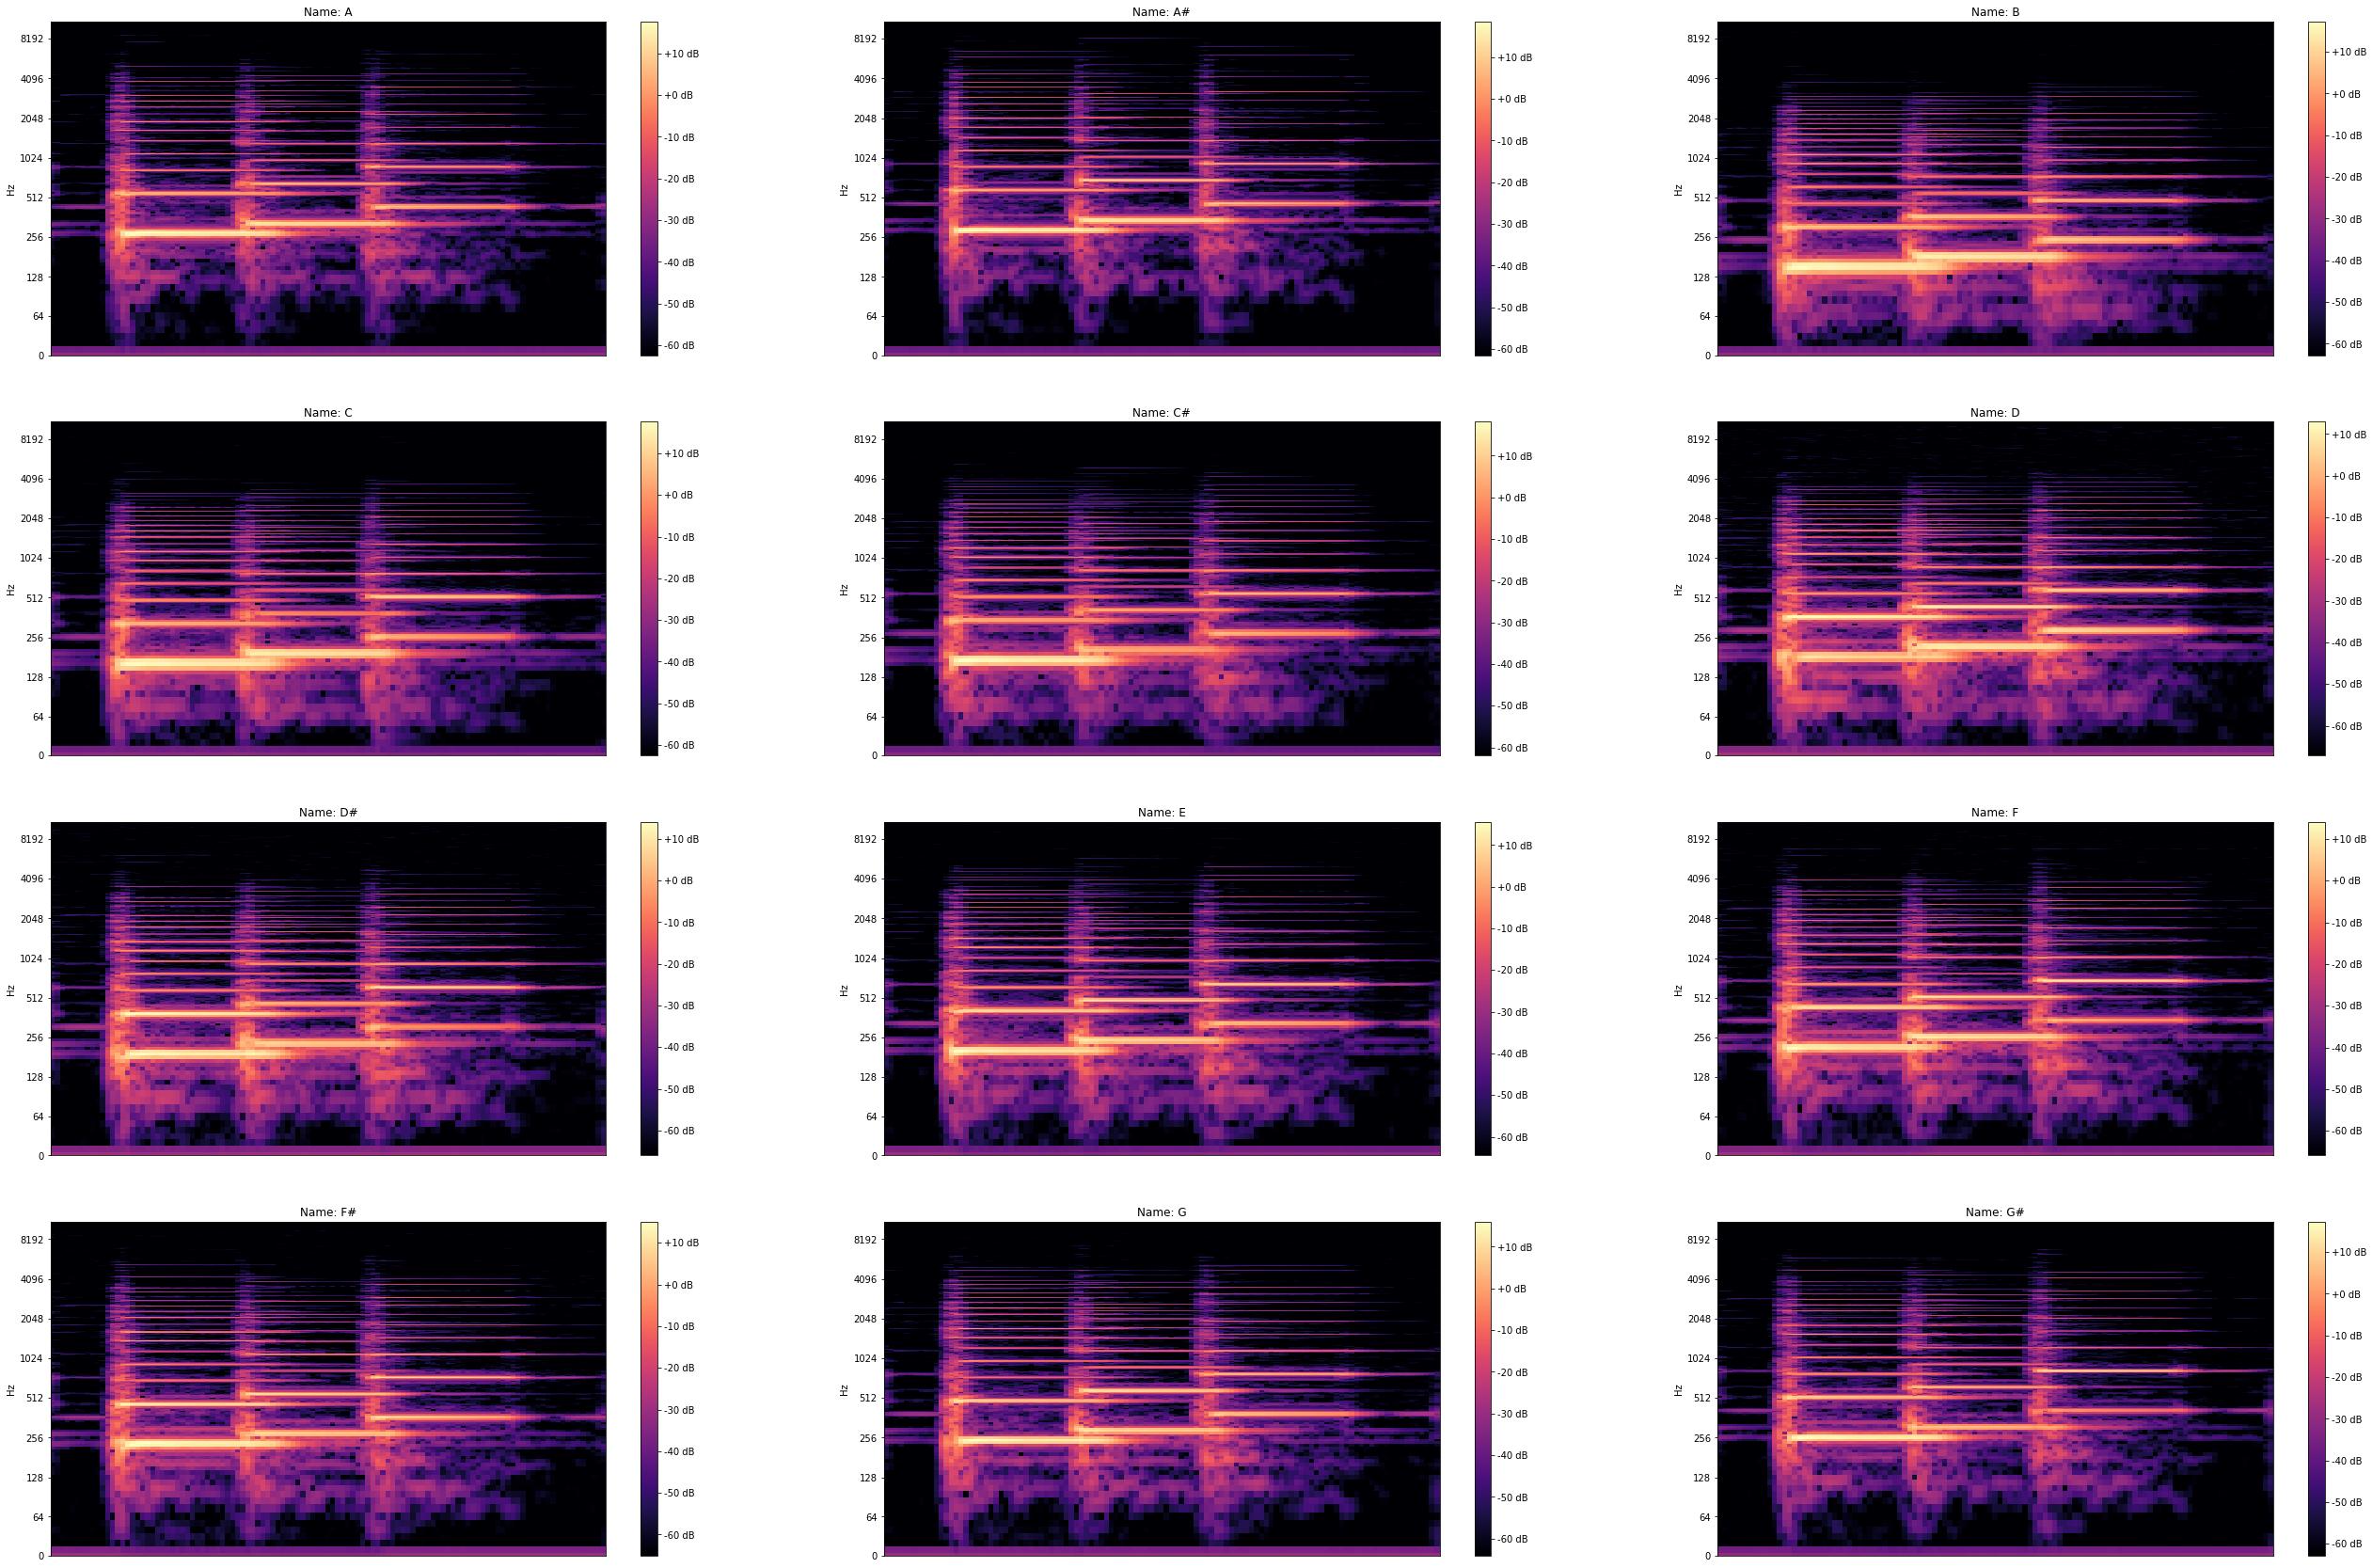

In [10]:
plt.figure(figsize=(45, 30))
for i in range(12):
    y = data_raw[168*i]
    plt.subplot(4,3,i+1)
    C = librosa.amplitude_to_db(np.abs(librosa.stft(y)))
    librosa.display.specshow(C, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Name: {}'.format(labels_names[labels[168*i]]))

In [11]:
magnitude_raw = []
for sample in tqdm(data):
    magnitude_raw.append(librosa.core.power_to_db(np.log1p(np.abs(librosa.stft(sample))**2)))
magnitude_raw = np.array(magnitude_raw)

100%|██████████████████████████████████████████████████████████████████████████████| 2016/2016 [00:37<00:00, 54.08it/s]


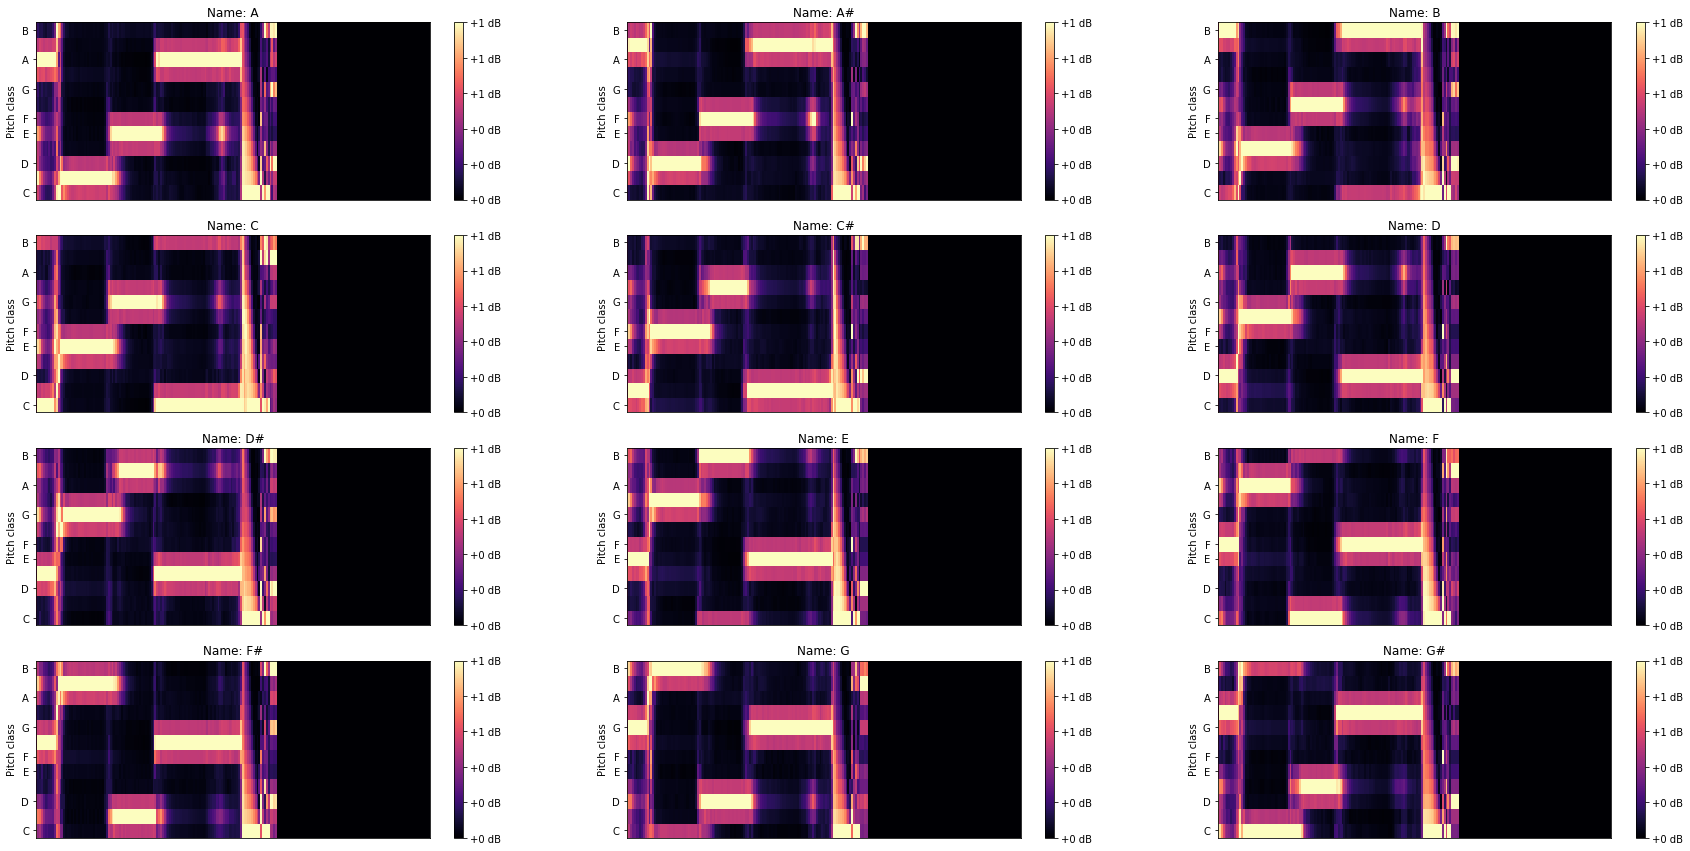

In [12]:
plt.figure(figsize=(30, 15))
for i in range(12):
    y = data[168*i]
    plt.subplot(4,3,i+1)
    C = librosa.feature.chroma_cqt(y)
    librosa.display.specshow(C, y_axis='chroma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Name: {}'.format(labels_names[labels[168*i]]))

In [13]:
chroma_cqt_raw = []
for sample in tqdm(data):
    chroma_cqt_raw.append(librosa.feature.chroma_cqt(sample))
chroma_cqt_raw = np.array(chroma_cqt_raw)

  3%|██▊                                                                             | 70/2016 [00:16<07:29,  4.33it/s]

KeyboardInterrupt: 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(chroma_cqt_raw, labels, test_size=0.4)

In [13]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [14]:
x,y,z = X_train.shape
X_train = X_train.reshape(x,y,z,1)

x,y,z = X_test.shape
X_test = X_test.reshape(x,y,z,1)

In [15]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [16]:
input_shape

(1025, 212, 1)

In [17]:
def get_cnn_v1(input_shape, num_classes):
    return Sequential([
        ### Warsty konwolucyjne dla input'u z chroma_cqt
    #Conv2D(filters=32, kernel_size=(8,8), activation='relu', input_shape=input_shape),
    #Conv2D(filters=32, kernel_size=(4,4), activation='relu', input_shape=input_shape), 
        ### Warsty konwolucyjne dla input'u z chroma_cqt
    Conv2D(filters=64, kernel_size=(8,8), activation='relu', input_shape=input_shape),
    #Conv2D(filters=64, kernel_size=(16,16), activation='relu', input_shape=input_shape), 
    #MaxPool2D(),
    Flatten(),
    Dropout(0.4),    
            
    Dense(num_classes, activation='softmax'),
])
  
def train_model(model, X_train, y_train, params_fit={}):
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    #logdir = os.path.join(HOME_DIR, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  
    model.fit(
          X_train,
          y_train,
          batch_size = params_fit.get('batch_size', 64),
          epochs = params_fit.get('epochs', 1),
          verbose=params_fit.get('verbose',1),
          validation_data = params_fit.get('validation_data', (X_train, y_train)),
          #callbacks= [tensorboard_callback]
          )
    
def predict(model_trained, X_test, y_test, scoring=accuracy_score):
    y_test_norm = np.argmax(y_test, axis=1)
    y_pred_prob = model_trained.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    return scoring(y_test_norm, y_pred) 

In [18]:
model = get_cnn_v1(input_shape, num_classes)
train_model(model, X_train, y_train)

Train on 1209 samples, validate on 1209 samples
Epoch 1/5
1209/1209 [==============================] - ETA: 12:41 - loss: 28.9265 - accuracy: 0.0000e+ - ETA: 10:40 - loss: 15857.5062 - accuracy: 0.0078 - ETA: 9:16 - loss: 21179.3531 - accuracy: 0.031 - ETA: 8:12 - loss: 22116.8845 - accuracy: 0.03 - ETA: 7:32 - loss: 21071.2802 - accuracy: 0.04 - ETA: 6:52 - loss: 18879.5645 - accuracy: 0.04 - ETA: 6:09 - loss: 16843.5387 - accuracy: 0.04 - ETA: 5:28 - loss: 14905.9378 - accuracy: 0.05 - ETA: 4:51 - loss: 13253.8058 - accuracy: 0.10 - ETA: 4:15 - loss: 11929.3105 - accuracy: 0.17 - ETA: 3:42 - loss: 10845.1389 - accuracy: 0.24 - ETA: 3:11 - loss: 9941.4370 - accuracy: 0.2995 - ETA: 2:42 - loss: 9176.8537 - accuracy: 0.346 - ETA: 2:13 - loss: 8521.6423 - accuracy: 0.383 - ETA: 1:44 - loss: 7953.5863 - accuracy: 0.422 - ETA: 1:17 - loss: 7456.5414 - accuracy: 0.456 - ETA: 51s - loss: 7020.1876 - accuracy: 0.452 - ETA: 24s - loss: 6630.5376 - accuracy: 0.47 - 561s 464ms/sample - loss: 631

KeyboardInterrupt: 

In [ ]:
predict(model, X_test, y_test)

In [ ]:
print(labels_names[np.argmax(model.predict(X_test)[0])])
print(labels_names[y_test[0].argmax()])

In [ ]:
model.summary()